# Solar Panel Defect Detection: a Hybrid YOLO and CNN+SVM Pipeline

This project presents a hybrid computer vision pipeline for defect detection in solar panels using infrared images. Due to the lack of a complete dataset containing full images with detailed defect classes, a two-stage approach was adopted:

1. **Patch-Level Classification**: A Convolutional Neural Network (CNN) was trained on cropped patches containing 12 distinct defect classes. These patches were assumed to be the result of prior bounding box annotations and serve as the basis for learning discriminative features.

2. **YOLO-Based Region Detection**: A YOLOv8 model is trained on a separate dataset of full infrared images containing bounding box annotations of defects. The YOLO model is not used for classifying the type of defect, but rather for detecting and cropping potential defect regions.

3. **Patch Reclassification with CNN+SVM**: The detected regions from YOLO are passed through the pre-trained CNN for feature extraction. These features are then classified using a Support Vector Machine (SVM), providing a refined class prediction based on the previously learned 12 defect types.

This modular architecture enables robust defect identification even when full-image labeled datasets are unavailable. The approach combines the localization power of YOLO with the discriminative capability of CNN+SVM trained on detailed patches, aiming for better generalization in real-world applications.


## Dataset Patches Overview

The dataset consists of 20,000 infrared images that are 24 by 40 pixels each, with 12 classes of solar modules presented below:

| Class Name     | Images | Description                                                               |
| -------------- | ------ | ------------------------------------------------------------------------- |
| Cell           | 1,877  | Hot spot occurring with square geometry in single cell.                   |
| Cell-Multi     | 1,288  | Hot spots occurring with square geometry in multiple cells.               |
| Cracking       | 941    | Module anomaly caused by cracking on module surface.                      |
| Hot-Spot       | 251    | Hot spot on a thin film module.                                           |
| Hot-Spot-Multi | 247    | Multiple hot spots on a thin film module.                                 |
| Shadowing      | 1,056  | Sunlight obstructed by vegetation, man-made structures, or adjacent rows. |
| Diode          | 1,499  | Activated bypass diode, typically 1/3 of module.                          |
| Diode-Multi    | 175    | Multiple activated bypass diodes, typically affecting 2/3 of module.      |
| Vegetation     | 1,639  | Panels blocked by vegetation.                                             |
| Soiling        | 205    | Dirt, dust, or other debris on surface of module.                         |
| Offline-Module | 828    | Entire module is heated.                                                  |
| No-Anomaly     | 10,000 | Nominal solar module.                                                     |


## Exploring the Data

First, let us analyze the distribution of defect classes within our training and testing datasets.

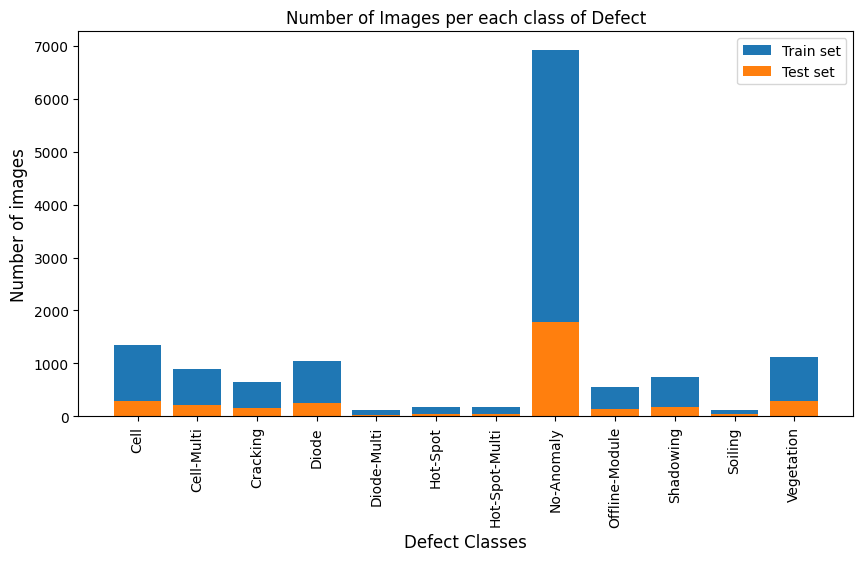

In [25]:
import os, random, shutil
import pandas as pd
import matplotlib.pyplot as plt

defects = os.listdir('../dataset_patches/data/train')

nums_train = {}
nums_test = {}
for anomaly in defects:
    nums_train[anomaly] = len(os.listdir('../dataset_patches/data/train' + '/' + anomaly))
    nums_test[anomaly] = len(os.listdir('../dataset_patches/data/test' + '/' + anomaly))

index = [n for n in range(12)]
plt.figure(figsize=(10, 5))
plt.bar(index, [n for n in nums_train.values()], label='Train set')
plt.bar(index, [n for n in nums_test.values()], label='Test set')
plt.xlabel('Defect Classes', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(index, defects, fontsize=10, rotation=90)
plt.title('Number of Images per each class of Defect')
plt.legend()

As we can see, the class ‘No-Anomaly’ has the largest number of images in our training dataset, with over 7,000 samples. In contrast, other classes such as 'Hot-Spot', 'Diode-Multi', 'Hot-Spot-Multi', and 'Soiling' have significantly fewer images, ranging between 120 and 180 samples each. This clearly indicates a class imbalance in the dataset, which we will address in the following steps. 

### Number of images within training and testing datasets

In [26]:
img_per_class = pd.DataFrame({
    "no. of images train": nums_train,
    "no. of images test": nums_test
})
img_per_class

,no. of images train,no. of images test
Cell,1346,295
Cell-Multi,890,208
Cracking,660,161
Diode,1049,255
Diode-Multi,131,27
Hot-Spot,173,42
Hot-Spot-Multi,172,48
No-Anomaly,6920,1774
Offline-Module,548,138
Shadowing,754,178


To deal with the imbalanced dataset, we can remove part of the images from 'No-Anomaly' feature so it matches a little bit more the other features such as 'Cell' and 'Vegetation' with more than 1,000 samples each.

For this, it seens reasonable to keep 2,000 images in the training dataset, since we will split it into train/validation datasets later on. Notice that its still an imbalanced dataset, however we can improve our model with this *Undersampling* technique combined with *data augmentation*.

In [27]:
# Original and destination folders
path_no_anomaly = "../dataset_patches/data/train/No-Anomaly"
backup_folder = "../dataset_patches/data/train_removed"
os.makedirs(backup_folder, exist_ok=True)

images = os.listdir(path_no_anomaly)

# Defines how many images to keep on training set
n_keep = 2000  
to_move = images[n_keep:]  

# Moves images
for img in to_move:
    shutil.move(os.path.join(path_no_anomaly, img),
                os.path.join(backup_folder, img))

### Dividing into Train/Val/Test sets

Now, we are going to divide our training dataset into train/val, where the validation samples match 20% of training dataset.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore # Chosen for multi-class training
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [4]:
# Preparing train and test patches
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    '../dataset_patches/data/train',
    image_size=(224,224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../dataset_patches/data/test',
    image_size=(224,224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True)

class_names = train_ds_raw.class_names

# Dividing train/val 
val_size = int(0.2 * tf.data.experimental.cardinality(train_ds_raw).numpy())
val_ds = train_ds_raw.take(val_size)
train_ds = train_ds_raw.skip(val_size)

Found 8973 files belonging to 12 classes.
Found 3477 files belonging to 12 classes.


### How the Dataset Patches Look Like?

To better understand our dataset, we visualize a few image samples from the training dataset. It looks like these patches were extracted from full-size infrared images using an object detection models and are labeled according to the type of defect or the absence of it. 

The dataset is organized into class-specific folders, allowing us to easily retrieve and visualize examples from each category.

Below, we show one image from each of two classes to illustrate the visual characteristics of different patch types.

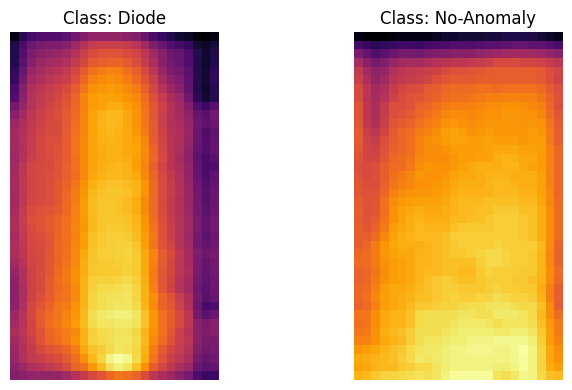

In [56]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

classes = ['Diode', 'No-Anomaly']

base_path = '../dataset_patches/data/train'

plt.figure(figsize=(8, 4))

for i, class_name in enumerate(classes):
    class_path = os.path.join(base_path, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    image = Image.open(image_path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(image, cmap='inferno')
    plt.title(f'Class: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()



It would be interesting if we had access to full infrared images annotated with all these detailed classes, allowing us to apply detection models directly. However, the availability of complete and well-annotated datasets is quite limited. 

In many cases, public datasets either contain only cropped patches of defects or lack precise bounding box annotations for each defect type. This limitation often requires us to rely on patch-level classification instead of full-image detection, unless we manually annotate or synthesize such datasets ourselves. 

To overcome this, we will use a method called *transfer learning* to train on full images despite the limited variety of available labels. By leveraging a pre-trained model, we can extract useful visual features and adapt the model to our specific task. 

This approach allows us to benefit from the knowledge learned on large-scale datasets and apply it to infrared solar panel images, even when detailed annotations are scarce.

## Pre-training Patches with CNN

Now, we are  going to train a CNN that recognizes the 12 types of defects from the infrared patches. 

### Data Augmentation

To improve the model's ability to generalize and prevent overfitting, we apply data augmentation techniques such as random rotations, flips, zooms, and brightness adjustments. These transformations simulate real-world variations, allowing the model to learn more robust features and adapt better to unseen data.

In [5]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

# Pre-processing of EfficientNet (normalization)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input


### Building the CNN Model with Transfer Learning

To classify the 12 types of defects in the infrared patch dataset, we build a Convolutional Neural Network (CNN) using *transfer learning*.

We start with a pre-trained *EfficientNetB0* model as the backbone. This model was originally trained on ImageNet and is known for its good performance with relatively few parameters. We remove its classification head by setting `include_top=False` and use it purely as a feature extractor.

We set `cnn_model.trainable = True` to fine-tune the entire network on our dataset, which can help improve performance since the domain (infrared images of solar defects) is quite different from the natural images in ImageNet.

The architecture includes the following components:

* Input layer for 224×224 RGB images.

* Data augmentation layer to artificially increase dataset variability (random flips, rotations, etc.).

* Preprocessing layer to apply the required normalization for EfficientNet.

* The EfficientNetB0 backbone.

* A Global Average Pooling layer to reduce the spatial dimensions into a single vector.

* A Dense output layer with 12 units and softmax activation, corresponding to our 12 defect classes.

In [ ]:
cnn_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
cnn_model.trainable= True # Fine-tuning

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = cnn_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

This model is now ready to be compiled and trained on the patch dataset.

In [31]:
# Compiling
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Training
model.fit(train_ds, validation_data=val_ds, epochs=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - accuracy: 0.4016 - loss: 1.7524 - val_accuracy: 0.5173 - val_loss: 1.4133


### Comparison: CNN Classifier vs CNN + SVM

Now we are going to extract features from CNN to train a SVM model and compare with CNN classifier by itself.

In [ ]:
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output
)

def extract_features_labels(dataset):
    feats = []
    labs  = []
    for xb, yb in dataset:
        f = feature_extractor(xb, training=False).numpy()
        feats.append(f)
        labs.append(yb.numpy())
    X = np.concatenate(feats, axis=0)
    y_onehot = np.concatenate(labs, axis=0)
    y = np.argmax(y_onehot, axis=1)
    return X, y

X_train, y_train = extract_features_labels(train_ds)
X_val,   y_val   = extract_features_labels(val_ds)
X_test,  y_test  = extract_features_labels(test_ds)

#### Support Vector Machine (SVM) Classifier Training and Evaluation

We will build an SVM classifier with an RBF kernel using a scikit-learn pipeline. The pipeline first standardizes the features with `StandardScaler`, then applies the SVC classifier with default hyperparameters (C=1.0 and gamma='scale').

To maximize the training data, we combine the training and validation sets before fitting the model. After training, we use the model to predict labels on the test set.

Finally, we evaluate the classifier's performance by printing the test accuracy and a detailed classification report, including precision, recall, and F1-score for each class.


In [ ]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

svm_clf.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))

y_pred = svm_clf.predict(X_test)

print(f"[SVM] Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n[SVM] Classification report:")
print(classification_report(y_test, y_pred, target_names=class_names))

[SVM] Test accuracy: 0.8041

[SVM] Classification report:
                precision    recall  f1-score   support

          Cell       0.58      0.75      0.65       295
    Cell-Multi       0.56      0.46      0.50       208
      Cracking       0.72      0.70      0.71       161
         Diode       0.95      0.95      0.95       255
   Diode-Multi       0.90      0.70      0.79        27
      Hot-Spot       0.49      0.50      0.49        42
Hot-Spot-Multi       0.48      0.65      0.55        48
    No-Anomaly       0.92      0.93      0.92      1774
Offline-Module       0.53      0.49      0.51       138
     Shadowing       0.73      0.70      0.71       178
       Soiling       0.76      0.25      0.38        51
    Vegetation       0.71      0.68      0.69       300

      accuracy                           0.80      3477
     macro avg       0.70      0.65      0.66      3477
  weighted avg       0.81      0.80      0.80      3477



#### CNN Model Evaluation on the Test Dataset

First, we prepare the test dataset for evaluation. We iterate through the test dataset batches, extracting the images and labels, and store them in lists. After collecting all batches, we concatenate the images and labels into single NumPy arrays. Since the labels are one-hot encoded, we convert them to class indices using `argmax`.

Next, we resize the test images to the input size expected by the CNN (224x224 pixels) and apply the necessary preprocessing function (preprocess_input) that matches the CNN architecture.

We then feed the preprocessed images into the trained CNN model to obtain class probability predictions. The predicted class for each sample is obtained by taking the index of the maximum probability.

Finally, we evaluate the model’s performance by printing the test accuracy and a detailed classification report that includes precision, recall, and F1-score for each class.

In [19]:
X_test_imgs = []
y_test = []

for batch_imgs, batch_labels in test_ds:
    X_test_imgs.append(batch_imgs.numpy())
    y_test.append(batch_labels.numpy())

X_test_imgs = np.concatenate(X_test_imgs)
y_test = np.concatenate(y_test)
y_test = np.argmax(y_test, axis=1)

In [20]:
X_test_imgs_resized = tf.image.resize(X_test_imgs, (224, 224))
X_test_cnn = preprocess_input(X_test_imgs_resized)

probs_cnn = model.predict(X_test_cnn, batch_size=32)
cnn_pred = probs_cnn.argmax(axis=1)

cnn_pred = np.argmax(probs_cnn, axis=1)
print(f"[CNN] Test accuracy: {accuracy_score(y_test, cnn_pred):.4f}")
print("\n[CNN] Classification report:")
print(classification_report(y_test, cnn_pred, target_names=class_names))

109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 577ms/step
[CNN] Test accuracy: 0.5887

[CNN] Classification report:
                precision    recall  f1-score   support

          Cell       0.39      0.75      0.51       295
    Cell-Multi       0.27      0.66      0.39       208
      Cracking       0.73      0.45      0.56       161
         Diode       0.91      0.87      0.89       255
   Diode-Multi       0.79      0.56      0.65        27
      Hot-Spot       0.29      0.14      0.19        42
Hot-Spot-Multi       0.55      0.38      0.44        48
    No-Anomaly       0.91      0.59      0.72      1774
Offline-Module       0.15      0.48      0.23       138
     Shadowing       0.56      0.42      0.48       178
       Soiling       1.00      0.08      0.15        51
    Vegetation       0.60      0.54      0.57       300

      accuracy                           0.59      3477
     macro avg       0.60      0.49      0.48      3477
  weighted avg       0.74      0.59      0.62      3477


### Comparison between CNN vs CNN+SVM

| **Class**      | **SVM F1-score** | **CNN F1-score** | **Better Model**  |
| -------------- | ---------------- | ---------------- | ----------------- |
| Cell           | 0.63             | 0.52             | SVM               |
| Cell-Multi     | 0.49             | 0.23             | SVM               |
| Cracking       | 0.71             | 0.64             | SVM               |
| Diode          | 0.91             | 0.83             | SVM               |
| Diode-Multi    | 0.74             | 0.54             | SVM               |
| Hot-Spot       | 0.45             | 0.43             | SVM (slightly)    |
| Hot-Spot-Multi | 0.61             | 0.48             | SVM               |
| No-Anomaly     | 0.91             | 0.87             | SVM               |
| Offline-Module | 0.48             | 0.21             | SVM               |
| Shadowing      | 0.70             | 0.45             | SVM               |
| Soiling        | 0.47             | 0.09             | SVM (much better) |
| Vegetation     | 0.64             | 0.39             | SVM               |


| **Metric**        | **SVM**    | **CNN** |
| ----------------- | ---------- | ------- |
| Accuracy          | **0.7955** | 0.6995  |
| Macro Avg (F1)    | **0.65**   | 0.45    |
| Weighted Avg (F1) | **0.79**   | 0.67    |


In [34]:
# Saving weigths for transfer learning
model.save_weights('patch_classifier.weights.h5')
feature_extractor.save('patch_backbone_model.h5')

In [6]:
from tensorflow.keras.models import load_model # type: ignore

In [ ]:
cnn_model = load_model("patch_backbone_model.h5")
#features = cnn_model.predict(patch_tensor)

## Training YOLO for Detecting Anomalies

The YOLO model receives a large image, in this case an entire infrared solar panel, and returns bounding boxes indicating where are the defects and which class it pertains.

Using YOLO first allows us to filter the image, detecting only relevant areas, since only a small part (that may contain defect) is going to be used for CNN+SVM models. For this, we start by importing YOLO from ultralytics library.

In [13]:
from ultralytics import YOLO 

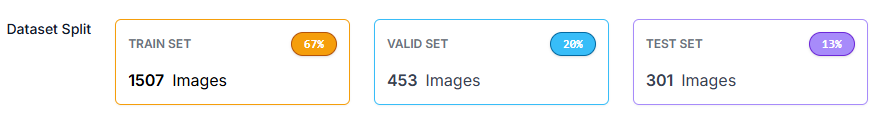

In [ ]:
defects = os.listdir('../dataset_full_images/dataset_yolov8/train')

nums_train_yolo = {}
nums_test_yolo = {}
for anomaly in defects:
    nums_train_yolo[anomaly] = len(os.listdir('../dataset_full_images/dataset_yolov8/train' + '/' + anomaly))
    nums_test_yolo[anomaly] = len(os.listdir('../dataset_full_images/dataset_yolov8/test' + '/' + anomaly))

img_per_class = pd.DataFrame(nums_train_yolo.values(), index=nums_test_yolo.keys(), columns=["no. of images"])
img_per_class

In [ ]:
# Loading yolov8 model
yolo_model = YOLO('yolov8n.yaml')

# Using the model
results = yolo_model.train(data='../dataset_full_images/dataset_yolov8/data.yaml',epochs=1, verbose=1)

In [ ]:
# Evaluate the model
yolo_model.val()

# Inference in new images
results = yolo_model('../dataset_full_images/dataset_yolov8/test/images/DJI_0015_R-JPG_5_png.rf.10ce851c4abab4b1f8ead125b16a36b8.jpg')
results

The outputs are: 

* A list of bounding boxes (x1, y1, x2, y2)

* The class pertaining to each box (Defect)

* Reliability (probability of being right)

Now we want to cut the detected boxes (extract patches), since CNN+SVM does not work with boxes directly. For this, we select only the region within the bounding box as follows:

In [ ]:
import cv2

output_folder = 'crops_detected'

os.makedirs(output_folder, exist_ok=True)

# It returns all detections (boxes + classes)
results = yolo_model.predict('../dataset_full_images/dataset_yolov8/train/images', save=False, conf=0.05, stream=True)  # stream=True para iterar

for r in results:
    im_path = r.path
    im_name = os.path.basename(im_path)
    img = cv2.imread(im_path)

    boxes = r.boxes  # Bounding boxes
    for i, box in enumerate(boxes):
        xyxy = box.xyxy.cpu().numpy().astype(int)[0]  # [x1, y1, x2, y2]
        x1, y1, x2, y2 = xyxy

        # Crop da imagem
        crop = img[y1:y2, x1:x2]

        # Salvar
        crop_name = f"{os.path.splitext(im_name)[0]}_crop{i}.jpg"
        cv2.imwrite(os.path.join(output_folder, crop_name), crop)
